In [18]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
from natsort import natsorted

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import numpy as np

from matplotlib.colors import LogNorm

from photutils.detection import DAOStarFinder
from photutils.aperture import CircularAperture, aperture_photometry
from photutils.background import Background2D

from astropy.stats import mad_std

import cometToolkit as ctk

from astropy.nddata import Cutout2D

In [49]:
rImage = ctk.GetImage("../DataProducts/vStacked.fits")

 id     xcentroid         ycentroid         sharpness           roundness1           roundness2      npix sky  peak         flux              mag        
--- ----------------- ----------------- ------------------ -------------------- -------------------- ---- --- ------ ----------------- ------------------
 15 926.5991618755206 926.4001123960127 0.5776587095594168 -0.12505930074381763 -0.09929226869444542  121 0.0 2159.0 97.24155291594944 -4.969629714420495


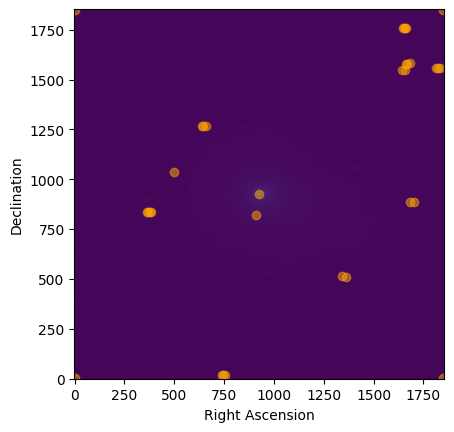

In [59]:
sources = ctk.SearchStars(rImage, showPlot=True)

#for s in sources:
#    print(s)

comet = sources[14]
print(comet)

id,xcenter,ycenter,aperture_sum
,pix,pix,
int64,float64,float64,float64
1,926.5991618755206,926.4001123960127,299941.5692451616


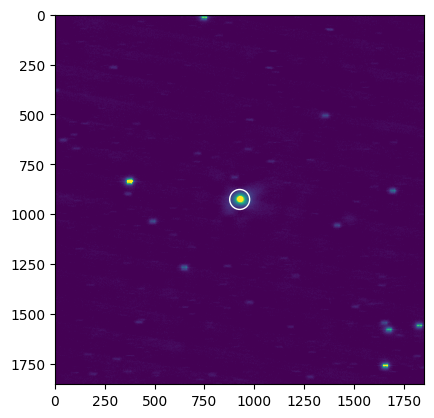

In [60]:
# Create aperture
apertureRadius = 50
apertureArcseconds = apertureRadius * 0.6

cometDistance = 0.585 * 1.496e8 # au to km
apertureKm =  cometDistance * np.tan(apertureArcseconds * np.pi / (180 * 3600) )

aperture = CircularAperture((comet["xcentroid"], comet["ycentroid"]), r=apertureRadius)

# Find background
background = Background2D(rImage, 50).background

# Plot
fig, ax = plt.subplots()

ax.imshow(rImage - background, vmin=0, vmax=80)
apertureCircle = plt.Circle((comet["xcentroid"], comet["ycentroid"]), apertureRadius, color="white", fill = 0)

ax.add_patch(apertureCircle)

phot_table = aperture_photometry(rImage - background, aperture)
phot_table

In [61]:
# Activity
from sbpy.data import Ephem
from sbpy.calib import solar_fluxd
from sbpy.activity import Afrho

import astropy.units as u

In [70]:
wavelength = 0.5501 * u.um

vMag = 14 # NEEDS TO BE CALCULATED WITH ZERO POINT AND FLUX

magnitude = vMag * u.ABmag # absolute magnitude

aper = apertureKm * u.km

eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

afrho = Afrho.from_fluxd(wavelength, magnitude, aper, eph)
print(afrho)

28.439085828742055 cm


# Function to do this for range of apertures

In [71]:
def FindActivityCurve(comet, apertureRange, showPlot=False):
    
    activity = []

    for apertureRadius in apertureRange:
        # Create aperture
        apertureArcseconds = apertureRadius * 0.6

        cometDistance = 0.585 * 1.496e8 # au to km
        apertureKm =  cometDistance * np.tan(apertureArcseconds * np.pi / (180 * 3600) )

        aperture = CircularAperture((comet["xcentroid"], comet["ycentroid"]), r=apertureRadius)

        # Find background
        background = Background2D(rImage, 50).background

        if showPlot:
            # Plot
            fig, ax = plt.subplots()

            ax.imshow(rImage - background, vmin=0, vmax=80)
            apertureCircle = plt.Circle((comet["xcentroid"], comet["ycentroid"]), apertureRadius, color="white", fill = 0)

            ax.add_patch(apertureCircle)

        phot_table = aperture_photometry(rImage - background, aperture)
        

        wavelength = 0.5501 * u.um

        vMag = 14 # NEEDS TO BE CALCULATED WITH ZERO POINT AND FLUX

        magnitude = vMag * u.ABmag # absolute magnitude

        aper = apertureKm * u.km

        eph = Ephem.from_dict({"rh": 1.566 * u.au, "delta": 0.585 * u.au})

        afrho = Afrho.from_fluxd(wavelength, magnitude, aper, eph)
        
        activity.append(afrho)

    return [apertureRange, activity]

In [ ]:
apRange, activity = FindActivityCurve(sources, )